In [1]:
import json, os, numpy as np, pandas as pd
from pathlib import Path

ROOT      = Path(".")                         # Notebook 所在目录
DATA_DIR  = Path("/home/mtang/vslib/mlpc2025_Team_Laborer/MLPC2025_classification")
WORK_DIR  = ROOT/"/home/mtang/vslib/mlpc2025_Team_Laborer/notebooks/Task3/tang"

WORK_DIR.mkdir(exist_ok=True)                 # 确保文件夹存在


In [2]:
meta      = pd.read_csv(DATA_DIR/"metadata.csv")
subset    = json.loads((WORK_DIR/"class_subset.json").read_text())
print("Target classes:", subset)


Target classes: ['Speech', 'Bird Chirp', 'Wind', 'Rain', 'Car', 'Stream/River', 'Waves', 'Guitar', 'Singing', 'Bell', 'Piano', 'Footsteps', 'Truck', 'Insect Buzz', 'Airplane']


In [3]:
LABEL_DIR = DATA_DIR/"labels"
file_labels = {}             # filename (str) -> Multi-hot (len=subset)

for lbl_path in LABEL_DIR.glob("*_labels.npz"):
    arr  = np.load(lbl_path, allow_pickle=False)
    y    = np.zeros(len(subset), dtype=int)

    for i, cls in enumerate(subset):
        if cls in arr.files and np.any(arr[cls]):
            y[i] = 1
    audio_id   = lbl_path.stem.replace("_labels", "")     # e.g. "426697"
    audio_fname = f"{audio_id}.mp3"
    file_labels[audio_fname] = y

In [6]:
from sklearn.model_selection import GroupShuffleSplit, StratifiedShuffleSplit
import numpy as np
from skmultilearn.model_selection import iterative_train_test_split

# Make dataframe for splitting
df_split = pd.DataFrame({
    "filename": list(file_labels.keys()),
    "y_code"  : [''.join(map(str, v)) for v in file_labels.values()]   # label pattern
})
groups = df_split["filename"]                 # group = file 自身
y_code = df_split["y_code"]

# 80% Train+Val , 20% Test  (group aware)
gss = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
trainval_idx, test_idx = next(gss.split(df_split, groups=groups))
trainval_df, test_df   = df_split.iloc[trainval_idx], df_split.iloc[test_idx]


#Iterative Stratification

# 需要把 multi-hot y 转成数组
trainval_files = trainval_df["filename"].tolist()
y_multi = np.stack([file_labels[fn] for fn in trainval_files], axis=0)  # shape (N, 15)

# X_dummy 只需占位；iterative_train_test_split 返回索引顺序
X_dummy = np.arange(len(trainval_files)).reshape(-1, 1)

X_tr, y_tr, X_val, y_val = iterative_train_test_split(
    X_dummy, y_multi, test_size=0.25     # = Val / (Train+Val)
)
# flatten 索引
train_idx = X_tr.flatten()
val_idx   = X_val.flatten()

train_df = trainval_df.iloc[train_idx]
val_df   = trainval_df.iloc[val_idx]


In [7]:
splits = {
    "train": train_df["filename"].tolist(),
    "val"  : val_df["filename"].tolist(),
    "test" : test_df["filename"].tolist(),
}
with open(WORK_DIR/"splits.json", "w") as f:
    json.dump(splits, f, indent=2)
print("Saved →", WORK_DIR/"splits.json")


Saved → /home/mtang/vslib/mlpc2025_Team_Laborer/notebooks/Task3/tang/splits.json


In [11]:
def load_features_and_labels(filelist, subset,
                             feat_dir=DATA_DIR/"audio_features"):
    X_list, y_list = [], []
    for fn in filelist:
        fpath = feat_dir / f"{Path(fn).stem}.npz"   # e.g. 426697.npz
        if not fpath.exists():
            print("⚠️ missing feature file:", fpath)
            continue

        feats = np.load(fpath, allow_pickle=False)
        if "mfcc" not in feats.files:               #健壮性
            continue

        X_file = feats["mfcc"]                      # (T, n_feat)
        y_file = np.tile(file_labels[fn], (X_file.shape[0], 1))
        X_list.append(X_file)
        y_list.append(y_file)

    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    return X, y



In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

def build_pipeline(use_pca=True, pca_var=0.95):
    steps = [("scaler", StandardScaler())]
    if use_pca:
        steps.append(("pca", PCA(n_components=pca_var, svd_solver="full")))
    return Pipeline(steps)


In [13]:
from joblib import dump

# 读取 split
split = json.loads((WORK_DIR/"splits.json").read_text())
X_train, y_train = load_features_and_labels(split["train"], subset)

pipe = build_pipeline(use_pca=True, pca_var=0.95)
pipe.fit(X_train)                         # 仅在 train 上拟合标准化 + PCA

dump(pipe, WORK_DIR/"pipeline.pkl")
print("Pipeline saved →", WORK_DIR/"pipeline.pkl")


Pipeline saved → /home/mtang/vslib/mlpc2025_Team_Laborer/notebooks/Task3/tang/pipeline.pkl


In [15]:
from joblib import load
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.dummy import DummyClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
import pandas as pd, json, numpy as np

subset   = json.loads((WORK_DIR/"class_subset.json").read_text())
splits   = json.loads((WORK_DIR/"splits.json").read_text())
pipe_pre = load(WORK_DIR/"pipeline.pkl")

X_tr, y_tr = load_features_and_labels(splits["train"], subset)
X_val, y_val = load_features_and_labels(splits["val"], subset)

def eval_model(clf, name):
    y_pred = clf.predict(X_val)
    return {
        "model": name,
        "f1_macro": f1_score(y_val, y_pred, average="macro", zero_division=0),
        "precision_macro": precision_score(y_val, y_pred, average="macro", zero_division=0),
        "recall_macro": recall_score(y_val, y_pred, average="macro", zero_division=0)
    }


In [16]:
dummy_major = OneVsRestClassifier(DummyClassifier(strategy="most_frequent"))
dummy_major.fit(X_tr, y_tr)
res_major = eval_model(dummy_major, "Dummy_Majority")


In [17]:
runs = []
for i in range(5):
    dummy_rand = OneVsRestClassifier(DummyClassifier(strategy="uniform", random_state=i))
    dummy_rand.fit(X_tr, y_tr)
    runs.append(eval_model(dummy_rand, f"Dummy_Random_run{i}"))

# 取均值
rand_avg = {"model": "Dummy_Random_mean",
            "f1_macro": np.mean([r["f1_macro"] for r in runs]),
            "precision_macro": np.mean([r["precision_macro"] for r in runs]),
            "recall_macro": np.mean([r["recall_macro"] for r in runs])}


In [18]:
logreg = OneVsRestClassifier(
            LogisticRegression(max_iter=1000, class_weight="balanced", solver="lbfgs"))
clf_log =  Pipeline([("pre", pipe_pre), ("clf", logreg)])
clf_log.fit(X_tr, y_tr)
res_log  = eval_model(clf_log, "LogReg_OVR")


In [19]:
results = pd.DataFrame([res_major, rand_avg, res_log])
results.to_csv(WORK_DIR/"baseline.csv", index=False)
print(results)


               model  f1_macro  precision_macro  recall_macro
0     Dummy_Majority  0.000000         0.000000      0.000000
1  Dummy_Random_mean  0.000000         0.000000      0.000000
2         LogReg_OVR  0.188588         0.111968      0.669948


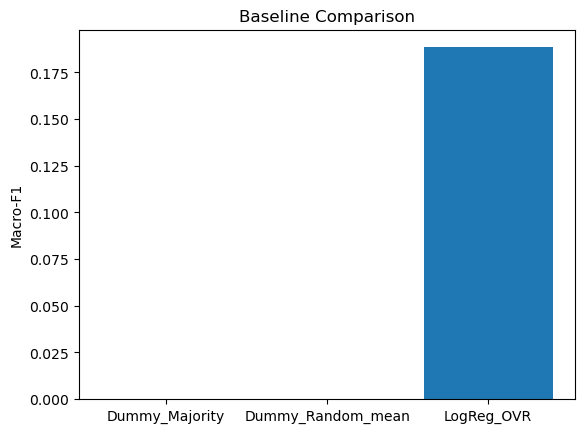

In [20]:
import matplotlib.pyplot as plt
plt.bar(results["model"], results["f1_macro"])
plt.ylabel("Macro-F1"); plt.title("Baseline Comparison")
plt.savefig(WORK_DIR/"baseline_bar.png", dpi=150, bbox_inches="tight")


## Baseline‐Stage Findings

| Model | Macro-F1 | Macro-Precision | Macro-Recall |
|-------|---------:|----------------:|-------------:|
| Dummy Majority | **0.000** | 0.000 | 0.000 |
| Dummy Random (mean of 5 runs) | **0.000** | 0.000 | 0.000 |
| Logistic Regression (OVR + balanced weights) | **0.189** | 0.112 | **0.670** |

### 1 · What the numbers tell us

* **Dummy baselines ≈ 0**   
  * 当我们总是输出各类别的众数（几乎全 0）或随机猜测时，宏-F1 为 0，说明  
    * **数据极度不平衡**：大多数帧对目标 15 类都是 negative。  
    * “什么都不做” 在宏指标下完全行不通——给我们 **最低参考线**。

* **Logistic Regression 提升到 0.189**   
  * 说明线性模型已能捕捉到一定判别信息。  
  * **宏-Recall = 0.67** 却 **宏-Precision = 0.11**  
    * 模型倾向于“多报一点”，召回了大部分正帧，但误报（FP）很多。  
    * 高 FP 可能来自：  
      1. 类别阈值默认 0.5 对于稀有类过低；  
      2. 特征（仅 MFCC）分离度有限；  
      3. 仍受不平衡影响，`class_weight="balanced"` 只是轻度缓解。

### 2 · 对后续实验的指导

| 观察 | 对策 / 下一步 |
|------|---------------|
| 高 Recall-低 Precision | • 尝试 **阈值校准**（per-class ROC/PR optimal cutoff）<br>• 引入更强判别模型（SVM RBF、RF、kNN） |
| 不平衡严重 | • 在模型网格中保留 `class_weight="balanced"` 选项<br>• 试验 **RandomOverSampler / SMOTE** 组合 |
| 仅用 MFCC | • 加入更多声学特征：Log-Mel、Chroma、Spectral contrast；<br>• 或在 Pipeline 里做特征拼接 / PCA |
| Logistic 仍低 | • 作为“及格线”：后续模型宏-F1 至少要 > 0.19，且提升 Precision 是关键 |

### 3 · 文件记录

结果已写入 `tang/baseline.csv`，图保存为 `tang/baseline_bar.png`，方便与后续模型对比。


In [27]:
# === common imports ===
import numpy as np, pandas as pd, json, yaml
from pathlib import Path
from joblib import load, dump

from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, make_scorer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

# iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

WORK_DIR = Path("tang")
DATA_DIR = Path("/home/mtang/vslib/mlpc2025_Team_Laborer/MLPC2025_classification")

subset   = json.loads((WORK_DIR/"class_subset.json").read_text())
splits   = json.loads((WORK_DIR/"splits.json").read_text())
pipe_pre = load(WORK_DIR/"pipeline.pkl")

macro_f1 = make_scorer(f1_score, average="macro", zero_division=0)

# --- helper ---
X_tr, y_tr = load_features_and_labels(splits["train"], subset)   # 帧级


In [28]:
mskf = MultilabelStratifiedKFold(
            n_splits=3,
            shuffle=True,
            random_state=42
        )


In [29]:
from sklearn.model_selection import GridSearchCV

# 1) SVM
svm_pipe = Pipeline([
    ("pre", pipe_pre),
    ("clf", OneVsRestClassifier(SVC()))
])
svm_grid = {
    "clf__estimator__kernel": ["rbf", "linear"],
    "clf__estimator__C": np.logspace(-3, 3, 7),
    "clf__estimator__gamma": np.logspace(-4, 0, 5)
}

# 2) Random Forest
rf_pipe = Pipeline([
    ("clf", RandomForestClassifier(
               n_jobs=-1,
               class_weight="balanced",
               random_state=42))
])
rf_grid = {
    "clf__n_estimators": [100, 300, 600],
    "clf__max_depth": [None, 10, 20],
    "clf__min_samples_leaf": [1, 5, 10]
}

# 3) kNN
knn_pipe = Pipeline([
    ("pre", pipe_pre),
    ("clf", KNeighborsClassifier())
])
knn_grid = {
    "clf__n_neighbors": list(range(1, 26, 4)),
    "clf__weights": ["uniform", "distance"]
}

model_dict = {
    "SVM":  (svm_pipe, svm_grid),
    "RF":   (rf_pipe,  rf_grid),
    "kNN":  (knn_pipe, knn_grid)
}


In [ ]:
best_params = {}
for name, (pipe, grid) in model_dict.items():
    print(f"\n=== Searching {name} ===")
    gs = GridSearchCV(
            estimator=pipe,
            param_grid=grid,
            scoring=macro_f1,
            cv=mskf,
            n_jobs=-1,
            verbose=2,
            refit=True            # 保存最佳模型
         )
    gs.fit(X_tr, y_tr)

    # 保存 cv 结果 → CSV
    pd.DataFrame(gs.cv_results_).to_csv(WORK_DIR/f"grid_{name}.csv", index=False)
    dump(gs.best_estimator_, WORK_DIR/f"best_{name}.pkl")

    best_params[name] = gs.best_params_
    print(f"Best {name}: {gs.best_score_:.3f}\n  {gs.best_params_}")
    
# 统一写成 yaml
with open(WORK_DIR/"best_params.yaml", "w") as f:
    yaml.dump(best_params, f)



=== Searching SVM ===
Fitting 3 folds for each of 70 candidates, totalling 210 fits
